## GOAL: predict whether an edge (interaction) between two proteins should be included in a pathway (label 1) or not (label 0)

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import EdgeConv, NNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

In [3]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 3


In [4]:
# set device to CUDA
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Data Loading:

**Pytorch Geometric `DataLoader` object from saved data:**

In [5]:
union_ppi = pd.read_csv('processed-data/union_ppi.txt', sep='\t', header=None)
unique_nodes = set(union_ppi[0].tolist() + union_ppi[1].tolist())
label_id_map = {label: idx for idx, label in enumerate(sorted(unique_nodes))}
num_nodes = len(label_id_map)
print(f"Total unique nodes: {num_nodes}")

Total unique nodes: 17407


In [6]:
data_list = torch.load('dataset.pt', weights_only=False)

In [7]:
print("Total number of data objects:", len(data_list))

for i, data in enumerate(data_list[:2]):
    print(f"\nData object {i}:")
    print("  Node features (x) size:", data.x.size())
    print("  Edge index size:", data.edge_index.size())
    print("  Edge attributes size:", data.edge_attr.size())
    print("  Edge labels (y) size:", data.y.size())

Total number of data objects: 820

Data object 0:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090, 1])
  Edge labels (y) size: torch.Size([202090, 1])

Data object 1:
  Node features (x) size: torch.Size([17407, 1])
  Edge index size: torch.Size([2, 202090])
  Edge attributes size: torch.Size([202090, 1])
  Edge labels (y) size: torch.Size([202090, 1])


### Class Weight Calculation:

- Calculate the weight for the positive class to handle class imbalance
- needed since the number of negative samples (non-selected edges) is much higher than positive samples (selected edges)
- weighting the **loss function** helps the model to learn from the minority class effectively

In [8]:
def calculate_class_weights(data_list):
    # concat all labels into single tensor
    y = torch.cat([data.y for data in data_list]).cpu().numpy()
    # count the number of pos and negative samples
    num_positive = y.sum()
    num_negative = len(y) - num_positive
    # calculate the weight --> ratio of negative samples to positive samples
    # so that loss function balances the contribution of both classes
    pos_weight = torch.tensor([num_negative / (2 * num_positive)]).to(device)
    return pos_weight

pos_weight = calculate_class_weights(data_list)
print(f"Positive class weight: {pos_weight.item()}")

Positive class weight: 7362.594285968186


### Train-test split:

In [9]:
train_ratio = 0.8
train_size = int(train_ratio * len(data_list))
test_size = len(data_list) - train_size

In [10]:
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

In [11]:
# Retrieve the file names from the train split
train_indices = train_dataset.indices 
train_file_names = [data_list[idx].file_name for idx in train_indices]

In [12]:
# 5) Save the train_file_names to a txt file
with open('train_files.txt', 'w') as f:
    for fname in train_file_names:
        f.write(f"{fname}\n")

### Edge Sampling

- technique that oversamples the positive edges to address class imbalance
- duplicate positive edges in dataset to increase representation during training - so that the model sees more examples
- oersampling helps the model to better learn the characteristics of the minority class (selected edges), improving its ability to classify them correctly

In [13]:
def edge_sampling(data_list, sampling_ratio=0.5):
    """
    Oversample edges from the minority class (positive edges).
    Args:
        data_list: List of PyG data objects.
        sampling_ratio: Ratio of minority class edges to add.
    Returns:
        Augmented data_list with oversampled positive edges.
    """
    augmented_data_list = []
    for data in data_list:
        y = data.y.cpu().numpy()
        # get the indices of positive and negtive edges
        positive_indices = np.where(y == 1)[0]
        negative_indices = np.where(y == 0)[0]
        # oversample positive edges
        num_positive = len(positive_indices)
        # fraction of +ve edges are randomly sampled with replacement
        num_samples = int(sampling_ratio * num_positive)
        # stores the indices of the sampled positive edges
        sampled_indices = np.random.choice(positive_indices, num_samples, replace=True)
        # connectivity information (source and target nodes) for the sampled edges:
        sampled_edge_index = data.edge_index[:, sampled_indices]
        # edge features for sampled edges:
        sampled_edge_attr = data.edge_attr[sampled_indices]
        # labels for sampled edges:
        sampled_y = data.y[sampled_indices]
        # connectivity information is updated by concatenating the original edges and the sampled edge:
        data.edge_index = torch.cat([data.edge_index, sampled_edge_index], dim=1)
        # edge features are updated by concatenating the original features and the sampled features:
        data.edge_attr = torch.cat([data.edge_attr, sampled_edge_attr], dim=0)
        # labels are updated by concatenating the original labels and the sampled label:
        data.y = torch.cat([data.y, sampled_y], dim=0)
        augmented_data_list.append(data)  
    return augmented_data_list

In [14]:
# apply edge sampling to the training dataset
train_dataset = edge_sampling(train_dataset, sampling_ratio=1.0)

### Make DataLoader:

- for batching and shuffling data
- feeds data into model during training and eval

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### Model Definition: using `EdgeConv` and `NNNConv` layers

- define GNN for edge classification 
- architecture designed to capture both node + edge features - needed for accurately classifying edges in PPI network
- use mlps to transform node + edge features into higher dim representations to capture pattersn in data

**Input Graph:**
- Node features (x): `[num_nodes, node_feat_dim]`
- Edge index (edge_index): `[2, num_edges]`
- Edge features (edge_attr): `[num_edges, edge_feat_dim]`

**Layers:**
- `EdgeConv` captures local patterns in the graph by considering the relationships between a node and its neighbors.

In [16]:
class EdgeClassificationGNN(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, edge_feat_dim, out_dim=1):
        """
        Args:
            node_feat_dim (int): Dimensionality of node features (1 in this case).
            hidden_dim (int): Hidden layer dimension.
            edge_feat_dim (int): Dimensionality of edge features (1 for prize).
            out_dim (int): Output dimension (1 for binary classification).
        """
        super(EdgeClassificationGNN, self).__init__()
        
        # --- First Layer: EdgeConv ---
        # PURPOSE: updates the features of each node by aggregating information from its direct neighbors.
        # MLP takes the concatenated features of a node and its neighbor --> outputs new feature vector
        self.mlp_edgeconv = nn.Sequential(
            nn.Linear(2 * node_feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # resutls from all neighbors are aggregated - 
        # 'max' selects the most important feature for each dimension
        self.conv1 = EdgeConv(nn=self.mlp_edgeconv, aggr='max')
        
        # --- Second Layer: NNConv ---
        # PURPOSE: updates node features by incorporating edge-specific information
        # MLP maps edge features to weight matrix --> which transforms the neighboring node features
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_feat_dim, hidden_dim * hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim * hidden_dim, hidden_dim * hidden_dim)
        )
        # transformed features from all neighbors aggregated by averaging contriutions from all neihbors
        self.conv2 = NNConv(in_channels=hidden_dim,
                            out_channels=hidden_dim,
                            nn=self.edge_nn,
                            aggr='mean')
        
        # --- Final Edge Classifier ---
        # combine the features of the source node, target node, and edge to predict the edge label
        # classifier is mlp that takes concatenated features and outputs raw score i.e. logit for binary classification
        self.edge_classifier = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_feat_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, out_dim)
        )
        
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # input node features and edge index into edge conv
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # input updated node features, edge index (edge_index), and edge features (edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        # for edge classification
        src, dst = edge_index
        edge_representation = torch.cat([x[src], x[dst], edge_attr], dim=1)
        logits = self.edge_classifier(edge_representation)
        # return raw logits instead of probabilities
        return logits  

### Training Setup & Loop

- initialize model, loss function, and optimizer
- `BCEWithLogitsLoss` loss function is chosen for binary classification - binary CEL with logitcs i.e raw scores
- `Adam` optimizer users to update model parameters during training

In [17]:
hidden_dim = 8 # dimension of hidden layer
node_feat_dim = 1 # dimension of node features
edge_feat_dim = 1 # dimension of edge features

In [18]:
model = EdgeClassificationGNN(node_feat_dim, hidden_dim, edge_feat_dim)
model = model.to(device)

In [19]:
# use class weighting in the loss function - assign higher weight to positive class i.e. minority class
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

- train the model using the following loop function 
- update model params to minimize loss functions 

In [20]:
def train(model, train_loader, epochs=20):
    model.train()  # set the model to training mode bc of layers beaviours
    # epoch loop:
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)  # move batch to the GPU
            # clear grads from previous batch
            optimizer.zero_grad()  
            # forward pass + get model predictions based on input batch
            out = model(batch) 
            # compute loss by comparing model pred (out) to ground truth labels
            loss = criterion(out, batch.y)  
            # compute grads wrt model params - backprop
            loss.backward()  
            # update model params using computed gradients - optimization
            optimizer.step() 
            # accumulate loss for current epoch
            epoch_loss += loss.item()  # Accumulate loss    
        # print average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [21]:
# Train the model.
train(model, train_loader, epochs=7)

/home/sanjeevs/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/7, Loss: 0.7530
Epoch 2/7, Loss: 0.4614
Epoch 3/7, Loss: 0.3685
Epoch 4/7, Loss: 0.3305
Epoch 5/7, Loss: 0.2864
Epoch 6/7, Loss: 0.2685
Epoch 7/7, Loss: 0.2520


### Evaluation & Precision-Recall Curve

- Evaluates the model's performance using precision, recall, F1-score, and AUC-ROC.
- These metrics provide a comprehensive assessment of the model's classification performance, especially important for imbalanced datasets

In [22]:
def evaluate_metrics_with_threshold(model, test_loader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            preds = (out.sigmoid() > threshold).float()  # Apply threshold to probabilities
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(out.sigmoid().cpu().numpy())  # Probabilities for AUC-ROC

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")

In [23]:
# # Test different thresholds
# thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
# for threshold in thresholds:
#     evaluate_metrics_with_threshold(model, test_loader, threshold)

In [24]:
def evaluate_metrics(model, test_loader):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            preds = (out > 0).float()  # Use 0 as threshold for logits
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(out.sigmoid().cpu().numpy())  # Probabilities for AUC-ROC

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")

In [25]:
evaluate_metrics(model, test_loader)

Precision: 0.0404, Recall: 1.0000, F1: 0.0777, AUC-ROC: 1.0000


**Plotting PRC:**

In [26]:
def plot_precision_recall_curve(model, test_loader):
    model.eval()
    y_true, y_score = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            y_true.extend(batch.y.cpu().numpy())
            y_score.extend(out.sigmoid().cpu().numpy())  # Probabilities for Precision-Recall curve

    precision, recall, thresholds = precision_recall_curve(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

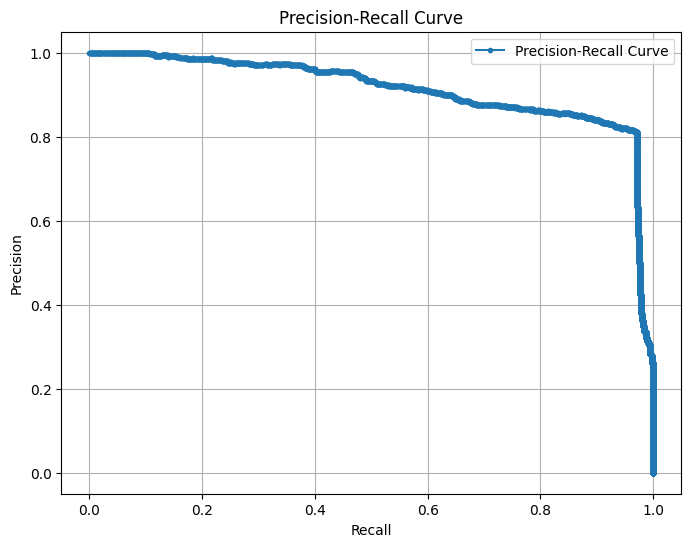

In [27]:
plot_precision_recall_curve(model, test_loader)

### Validate Prediction with Test Pathway

**Extract single graph**

In [28]:
single_test_data = test_dataset[-2].to(device)

In [29]:
single_test_data.x.size()

torch.Size([17407, 1])

**Run model forward pass for single test graph**

In [30]:
model.eval()
with torch.no_grad():
    logits = model(single_test_data)
    y_prob = torch.sigmoid(logits).cpu().numpy()
    y_pred = (y_prob > 0.5).astype(int)
    y_true = single_test_data.y.cpu().numpy()

**Identify TP/FP/FN edges**

In [31]:
tp_mask = (y_true == 1) & (y_pred == 1)
fp_mask = (y_true == 0) & (y_pred == 1)
fn_mask = (y_true == 1) & (y_pred == 0)

In [32]:
num_tp = np.sum(tp_mask)
num_fp = np.sum(fp_mask)
num_fn = np.sum(fn_mask)

print(f"True Positives (TP): {num_tp}")
print(f"False Positives (FP): {num_fp}")
print(f"False Negatives (FN): {num_fn}")

True Positives (TP): 8
False Positives (FP): 55
False Negatives (FN): 0


**Convert to NetworkX graph (only plot TP/FP/FN edges)**

In [33]:
edge_index = single_test_data.edge_index.cpu().numpy()
G = nx.Graph()

In [34]:
# add only TP/FP/FN edges to reduce clutter
for i, (src, dst) in enumerate(edge_index.T):
    if tp_mask[i] or fp_mask[i] or fn_mask[i]:
        G.add_edge(src, dst)

**Assign edge colors**

In [35]:
edge_colors = []
for i, (src, dst) in enumerate(edge_index.T):
    if tp_mask[i]:
        # TP -> green
        edge_colors.append("green")  
    elif fp_mask[i]:
        # FP -> red
        edge_colors.append("red")    
    elif fn_mask[i]:
        # FN -> blue
        edge_colors.append("blue")  

**Draw the graph (only TP/FP/FN edges)**

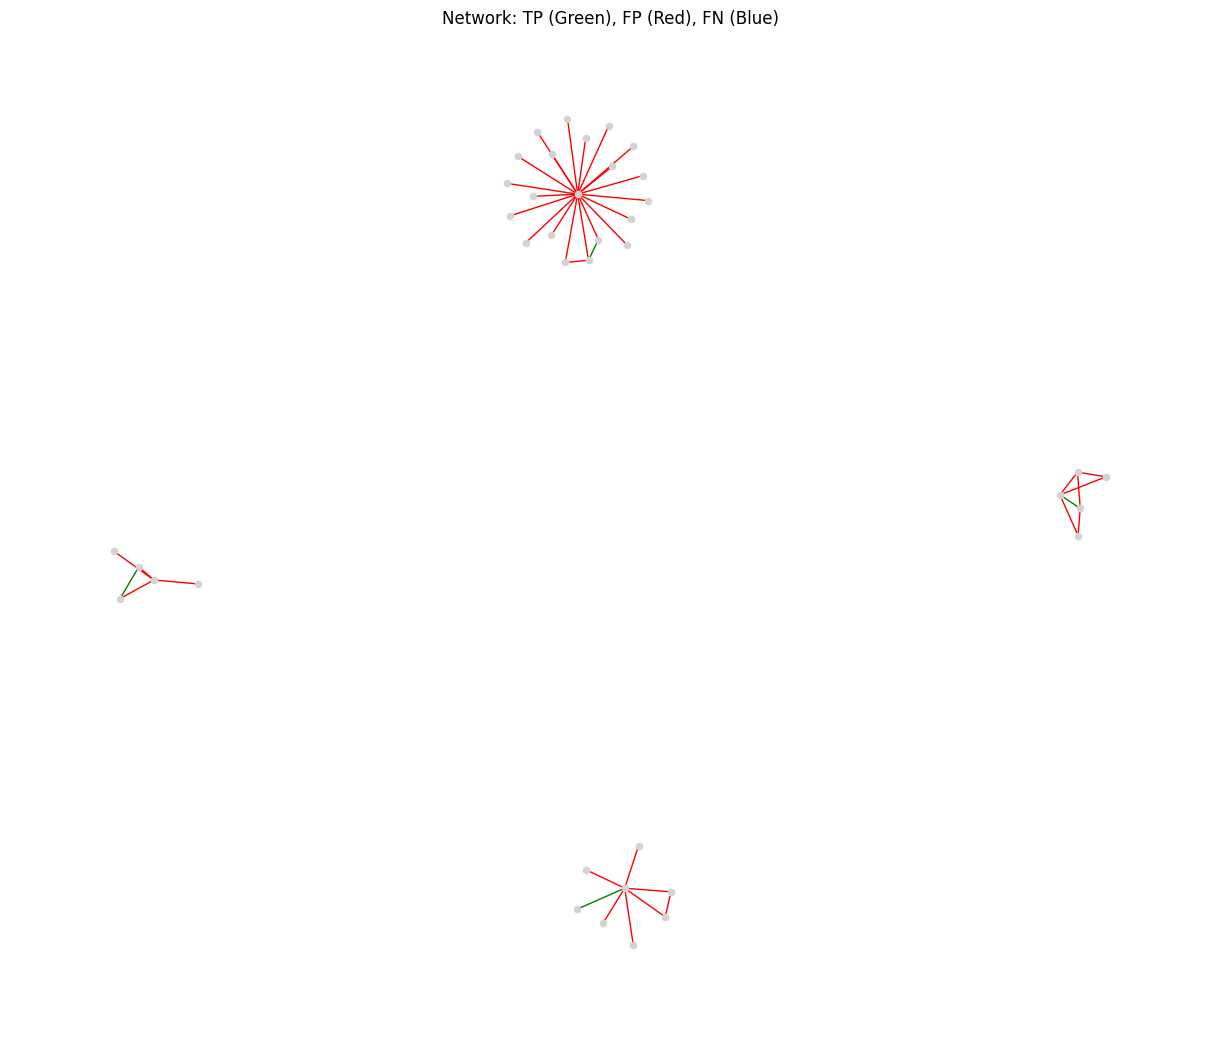

In [36]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.15, iterations=50)  # Force-directed layout
nx.draw(
    G,
    pos,
    edge_color=edge_colors,
    node_size=20,
    node_color="lightgray",
    width=1.0,
    with_labels=False,
)
plt.title("Network: TP (Green), FP (Red), FN (Blue)")
plt.show()

**Print metrics for this graph**

In [37]:
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Precision: 0.1270, Recall: 1.0000, F1: 0.2254
